<a href="https://colab.research.google.com/github/Asadtheanalyst/Project/blob/main/EDA_Household_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")

<ipython-input-2-6d34f3c5fabf>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Reading data

In [3]:
energy_usage_df = pd.read_csv("/content/D202.csv")

In [4]:
energy_usage_df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


Seeing the data shape mean how many rows and columns in a dataset

In [5]:
n_rows, n_cols = energy_usage_df.shape

print(f"There are {n_rows} rows and {n_cols} columns in the dataset.")

There are 70368 rows and 8 columns in the dataset.


Count of unique values by columns

In [6]:
def unique_value_count(df: pd.DataFrame):
    df_nunique = df.nunique().reset_index()
    df_nunique['dtype'] = df.dtypes.reset_index().loc[:, 0]
    df_nunique.columns = ['column', 'nunique', 'dtype']

    display(df_nunique)

In [7]:
unique_value_count(df=energy_usage_df)

,column,nunique,dtype
0,TYPE,1,object
1,DATE,733,object
2,START TIME,96,object
3,END TIME,96,object
4,USAGE,200,float64
5,UNITS,1,object
6,COST,49,object
7,NOTES,0,float64


Missing value stats by columns

In [8]:
def missing_value_stats(df: pd.DataFrame):
    """
        Considering the count of NaN points only
    """
    num_rows = df.shape[0]
    # Missing value count by columns
    df_missing = df.isna().sum().reset_index()
    # Renaming columns
    df_missing.columns = ['column', 'missing_values']
    # Getting only those columns having missing values > 0
    df_missing = df_missing[df_missing['missing_values'] > 0]
    df_missing.reset_index(drop=True, inplace=True)
    # Calculating percentage of missing
    df_missing['missing_percentage'] = df_missing['missing_values'].apply(
        lambda missing_value: round((missing_value / num_rows) * 100, 2)
    )

    if df_missing.shape[0] > 0:
        display(df_missing)
    else:
        return "The dataset has no NaNs"

In [9]:
missing_value_stats(df=energy_usage_df)

,column,missing_values,missing_percentage
0,NOTES,70368,100.0


Data Cleaning

In [10]:
# Dropping unnecessary columns
energy_usage_df = energy_usage_df.drop(columns=["TYPE", "UNITS", "END TIME", "NOTES"], errors="ignore")

# Converting COST column to float
energy_usage_df["COST"] = energy_usage_df["COST"].str.replace("$", "", regex=False).astype(float)

# Creating timestamp column
add_prefix_lambda = lambda start_time: "0"+ start_time if int(start_time.split(":")[0]) < 12 else start_time
energy_usage_df["START TIME"] = energy_usage_df["START TIME"].apply(add_prefix_lambda)

energy_usage_df["timestamp"] = energy_usage_df["DATE"] + " " + energy_usage_df["START TIME"]
energy_usage_df["timestamp"] = pd.to_datetime(energy_usage_df["timestamp"])

energy_usage_df = energy_usage_df[["timestamp", "USAGE", "COST"]]
energy_usage_df.columns = ["timestamp", "usage", "cost"]

In [11]:
display(energy_usage_df.head())


,timestamp,usage,cost
0,2016-10-22 00:00:00,0.01,0.0
1,2016-10-22 00:15:00,0.01,0.0
2,2016-10-22 00:30:00,0.01,0.0
3,2016-10-22 00:45:00,0.01,0.0
4,2016-10-22 01:00:00,0.01,0.0


Data Preparation

In [12]:
# Hourly
hourly_usage_df = energy_usage_df.resample("1H", on="timestamp").sum()

# Daily
daily_usage_df = hourly_usage_df.resample("1D").sum()

# Monthly
monthly_usage_df = daily_usage_df.resample("1M").sum()

In [13]:
display(hourly_usage_df.head())

,usage,cost
timestamp,,
2016-10-22 00:00:00,0.04,0.0
2016-10-22 01:00:00,0.04,0.0
2016-10-22 02:00:00,0.08,0.0
2016-10-22 03:00:00,0.04,0.0
2016-10-22 04:00:00,0.04,0.0


Adding features

In [14]:
monthly_usage_df["per_unit_cost"] = monthly_usage_df["cost"]/monthly_usage_df["usage"]
monthly_usage_df["year"] = monthly_usage_df.index.year.astype(str)
monthly_usage_df["month_name"] = monthly_usage_df.index.month_name().str[:3]

monthly_usage_df["usage_month"] = monthly_usage_df["month_name"] + "-" + monthly_usage_df["year"]

monthly_usage_df = monthly_usage_df.drop(columns=["year", "month_name"], errors="ignore")

display(monthly_usage_df.head())

,usage,cost,per_unit_cost,usage_month
timestamp,,,,
2016-10-31,85.60,15.24,0.178037,Oct-2016
2016-11-30,404.36,73.56,0.181917,Nov-2016
2016-12-31,624.52,122.30,0.195830,Dec-2016
2017-01-31,742.40,145.38,0.195824,Jan-2017
2017-02-28,458.12,85.78,0.187244,Feb-2017


**Viz**
Finding relation between power usage and consumption cost

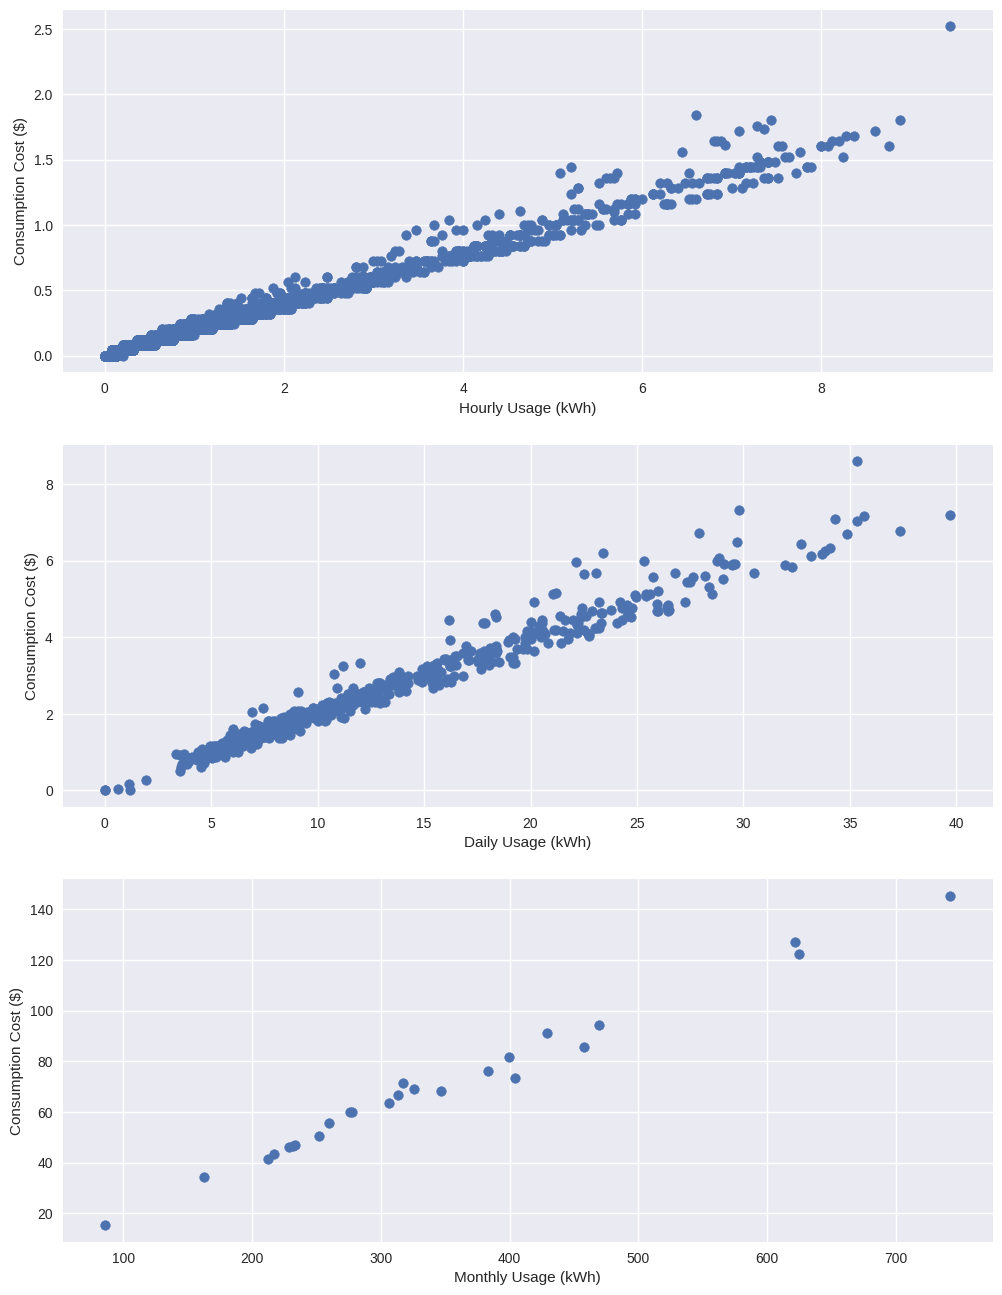

In [15]:
plt.figure(figsize=(12, 16))

plt.subplot(3, 1, 1)
plt.scatter(hourly_usage_df["usage"], hourly_usage_df["cost"])
plt.xlabel("Hourly Usage (kWh)")
plt.ylabel("Consumption Cost ($)")

plt.subplot(3, 1, 2)
plt.scatter(daily_usage_df["usage"], daily_usage_df["cost"])
plt.xlabel("Daily Usage (kWh)")
plt.ylabel("Consumption Cost ($)")

plt.subplot(3, 1, 3)
plt.scatter(monthly_usage_df["usage"], monthly_usage_df["cost"])
plt.xlabel("Monthly Usage (kWh)")
plt.ylabel("Consumption Cost ($)")

plt.show()

**Data points where monthly usage > 500 kWh**

In [16]:
display(monthly_usage_df.query("usage > 500"))

,usage,cost,per_unit_cost,usage_month
timestamp,,,,
2016-12-31,624.52,122.30,0.195830,Dec-2016
2017-01-31,742.40,145.38,0.195824,Jan-2017
2017-12-31,621.80,127.14,0.204471,Dec-2017


In [17]:
display(monthly_usage_df.query("usage_month == 'Jan-2018'"))

,usage,cost,per_unit_cost,usage_month
timestamp,,,,
2018-01-31,469.16,94.28,0.200955,Jan-2018


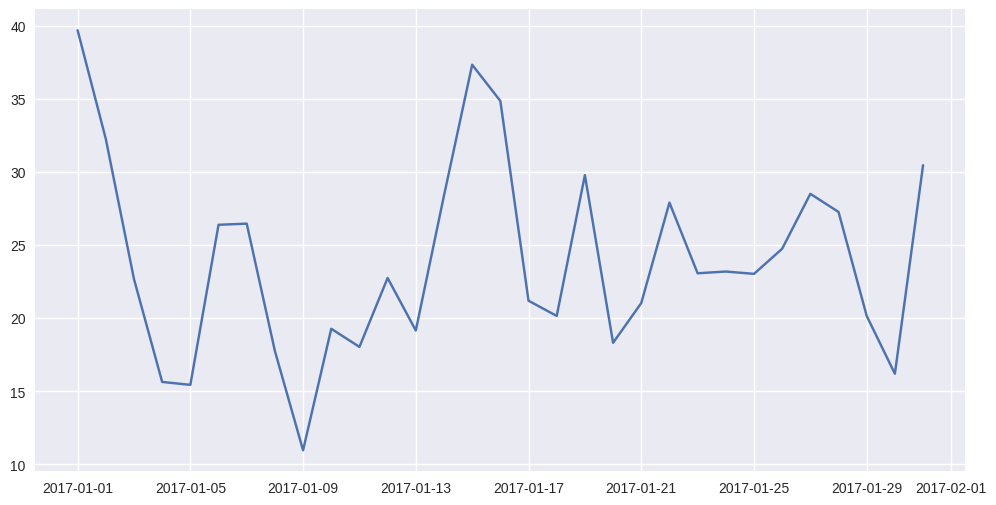

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(daily_usage_df.loc["2017-01-01": "2017-01-31", "usage"])
plt.show()

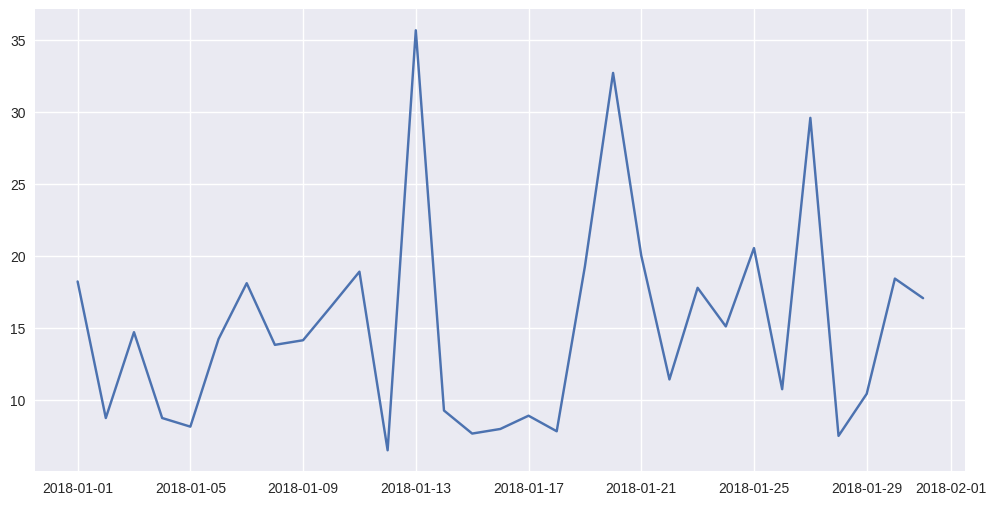

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(daily_usage_df.loc["2018-01-01": "2018-01-31", "usage"])
plt.show()

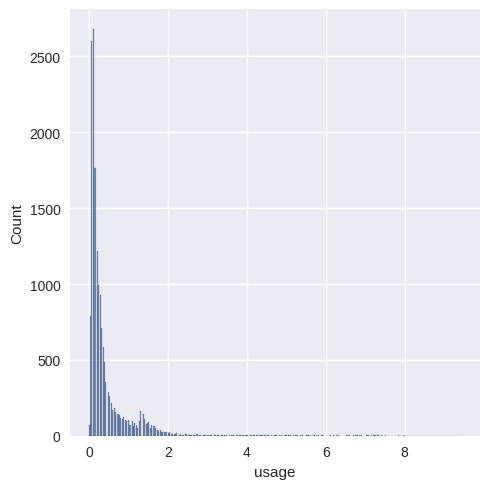

In [20]:
sns.displot(hourly_usage_df.usage)
plt.show()

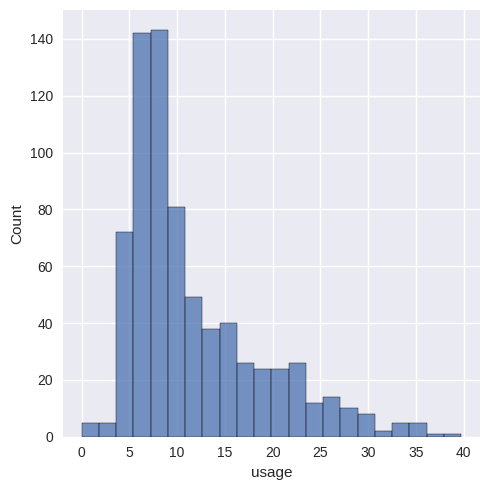

In [21]:
sns.displot(daily_usage_df.usage)
plt.show()

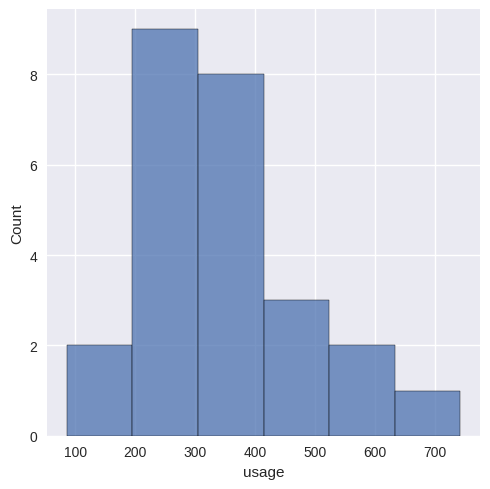

In [22]:
sns.displot(monthly_usage_df.usage)
plt.show()

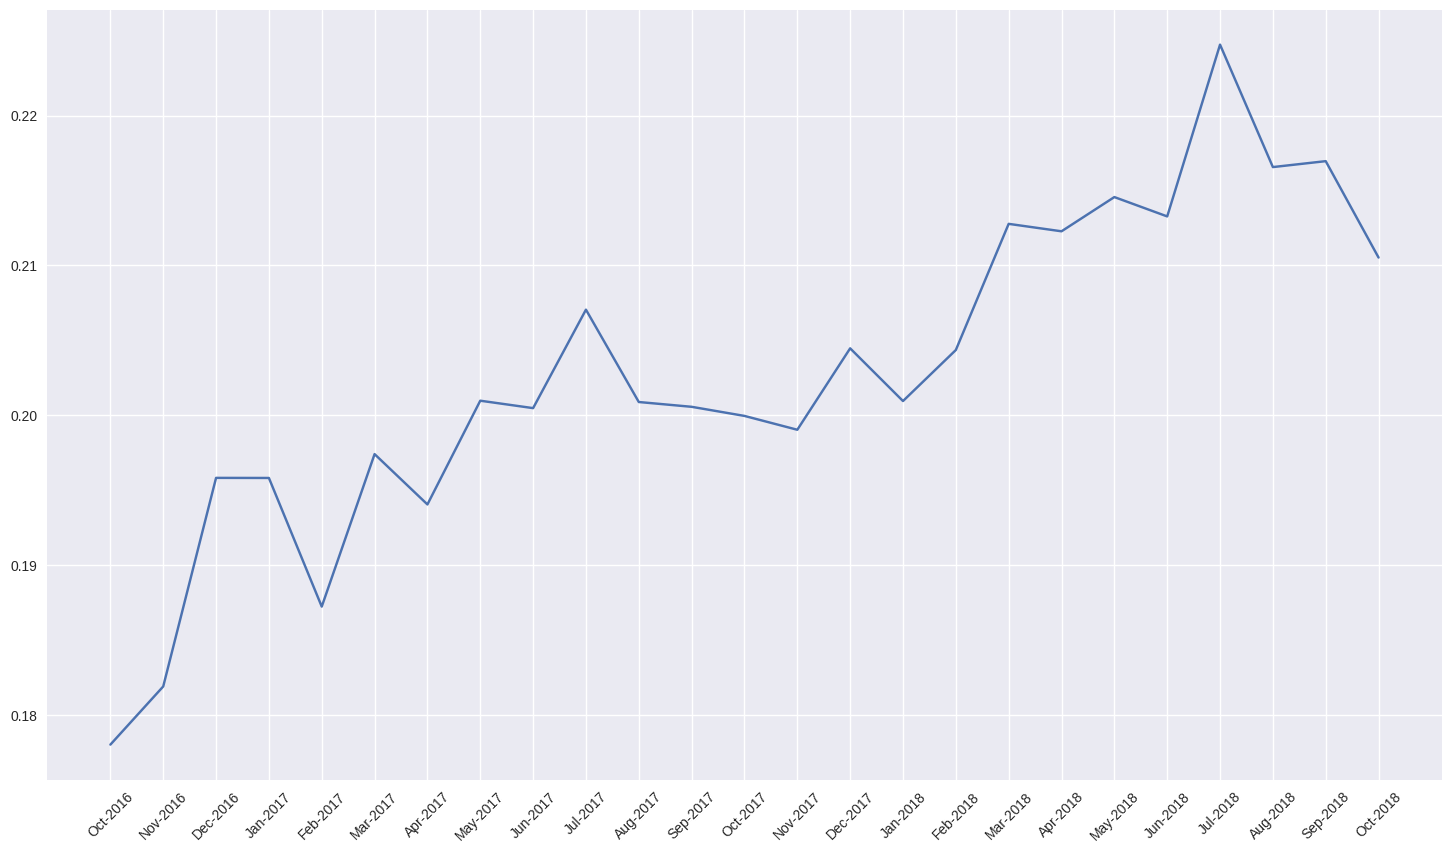

In [23]:
plt.figure(figsize=(18, 10))

plt.plot(monthly_usage_df["usage_month"], monthly_usage_df["per_unit_cost"])
plt.xticks(rotation=45)
plt.show()

In [24]:
energy_usage_df.describe()

,usage,cost
count,70368.000000,70368.000000
mean,0.121941,0.024684
std,0.210507,0.042646
min,0.000000,0.000000
25%,0.030000,0.010000
50%,0.050000,0.010000
75%,0.120000,0.020000
max,2.360000,0.650000


from matplotlib import pyplot as plt
_df_0['usage'].plot(kind='hist', bins=20, title='usage')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['cost'].plot(kind='hist', bins=20, title='cost')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='usage', y='cost', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['usage'].plot(kind='line', figsize=(8, 4), title='usage')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['cost'].plot(kind='line', figsize=(8, 4), title='cost')
plt.gca().spines[['top', 'right']].set_visible(False)

In [29]:
!pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 26.5 MB/s eta 0:00:00


In [30]:
import sweetviz as sv


In [31]:
import pandas as pd

# Replace 'your_dataset.csv' with the path to your CSV file
df = pd.read_csv('/content/D202.csv')

In [32]:
report = sv.analyze(df)

# Generate an HTML report
report.show_html('Sweetviz_Report.html')

                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()


Report Sweetviz_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



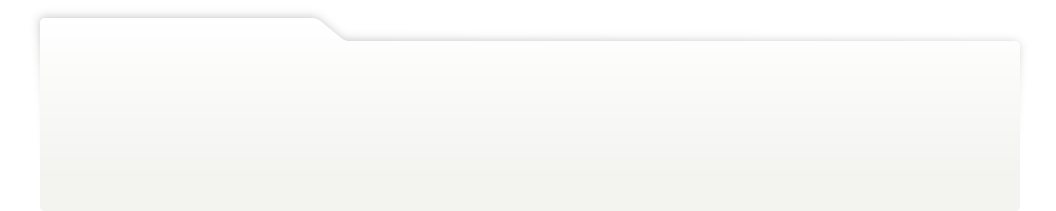
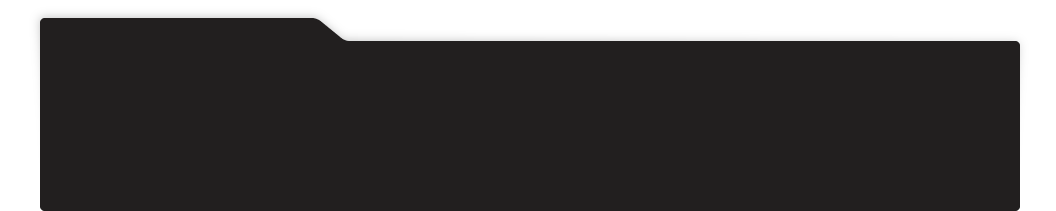
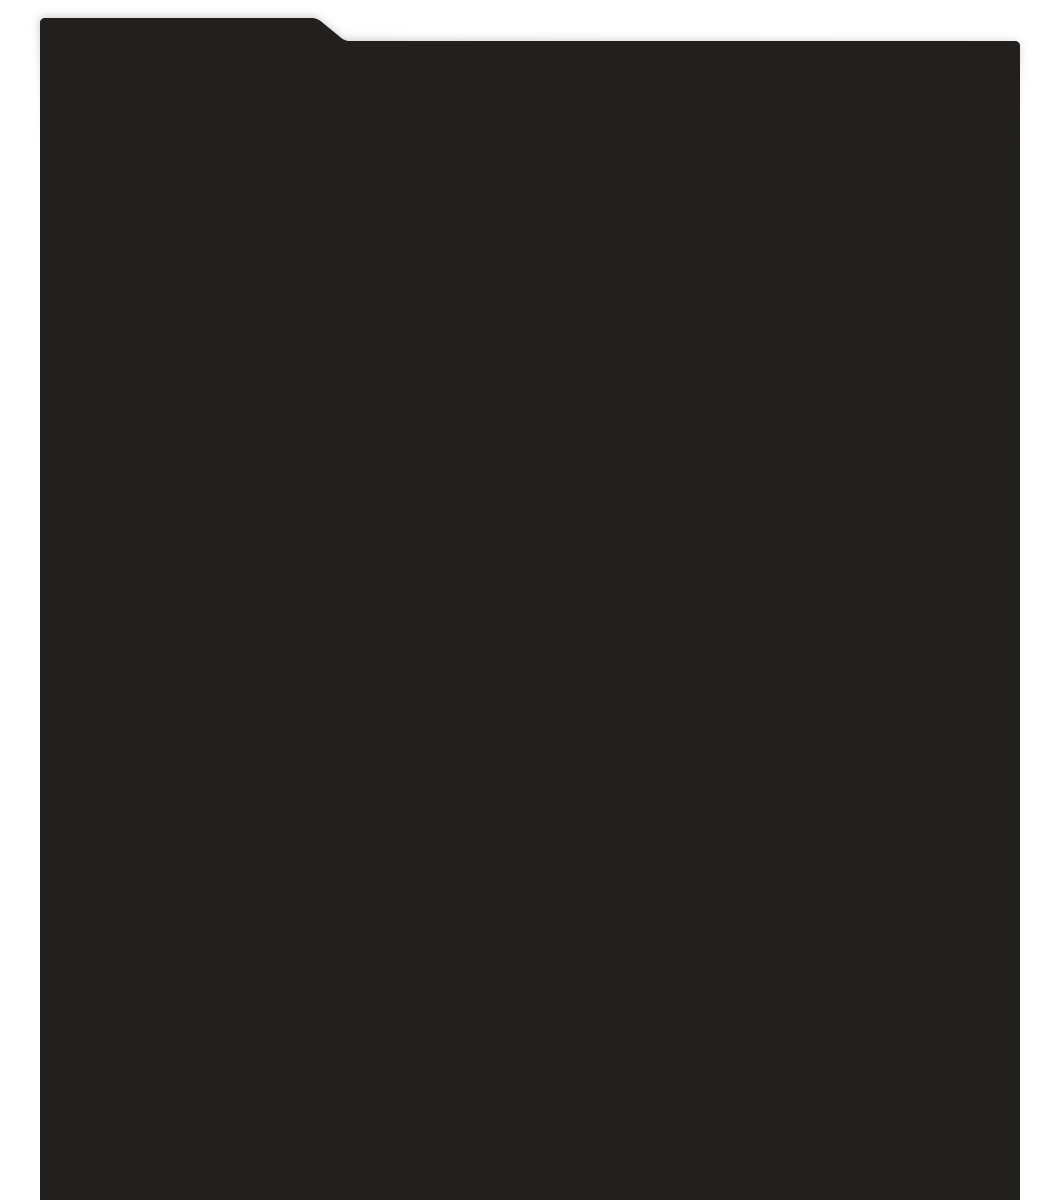
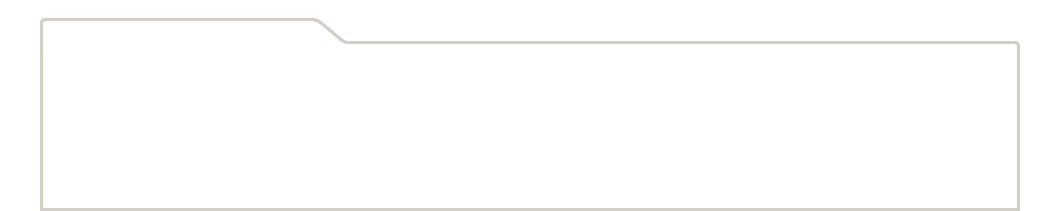
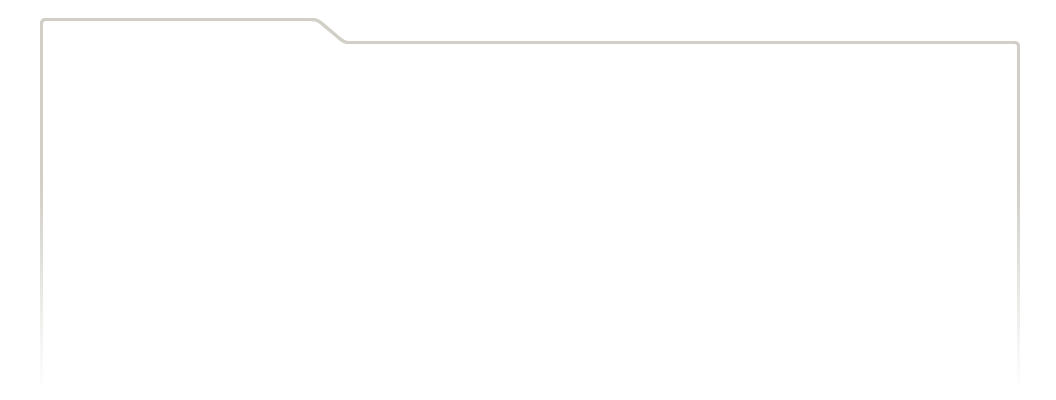
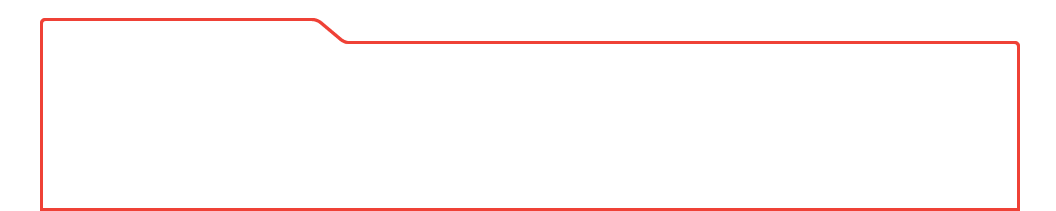
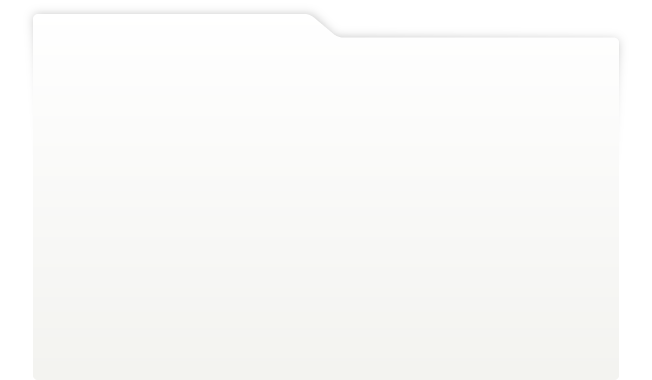
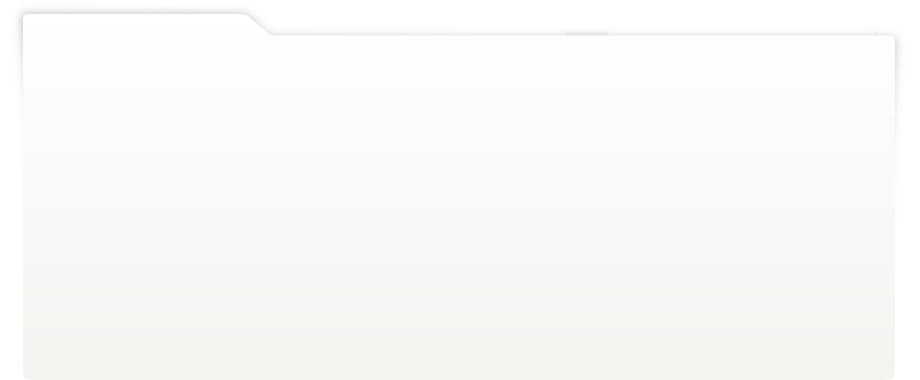
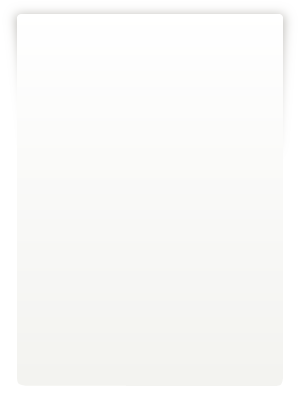
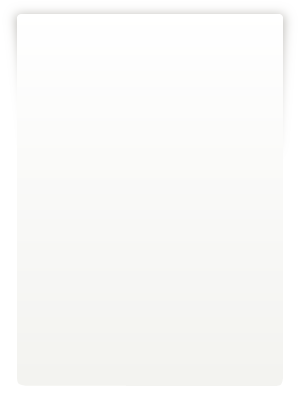
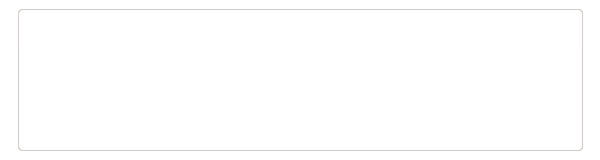
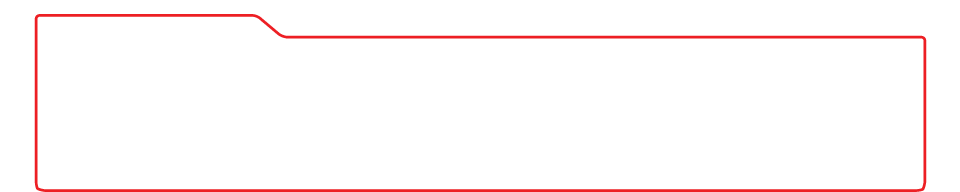
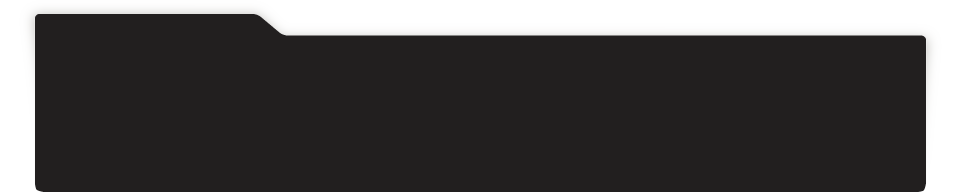
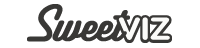
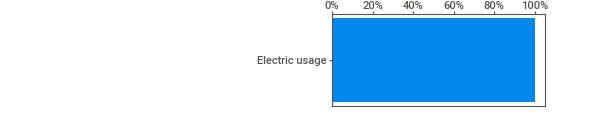
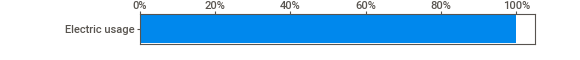
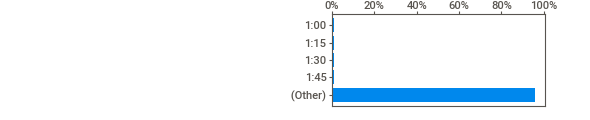
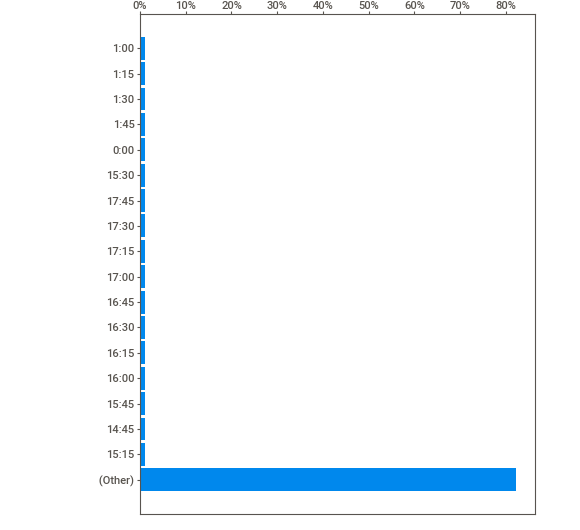
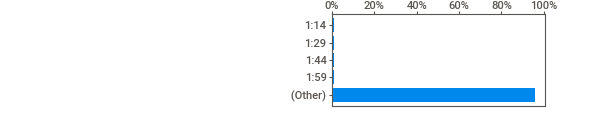
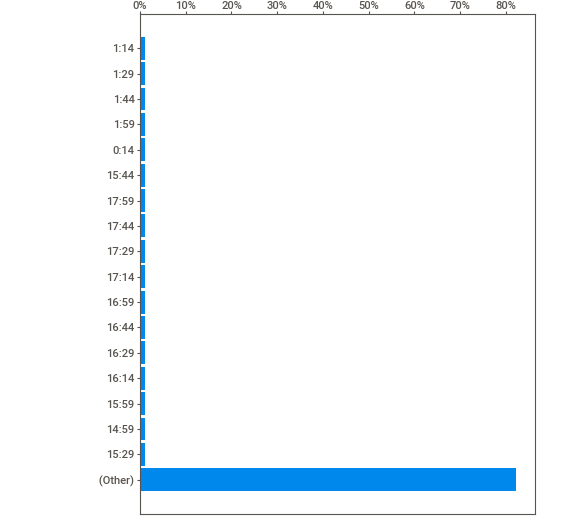
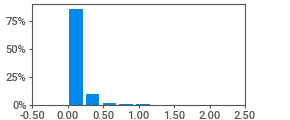
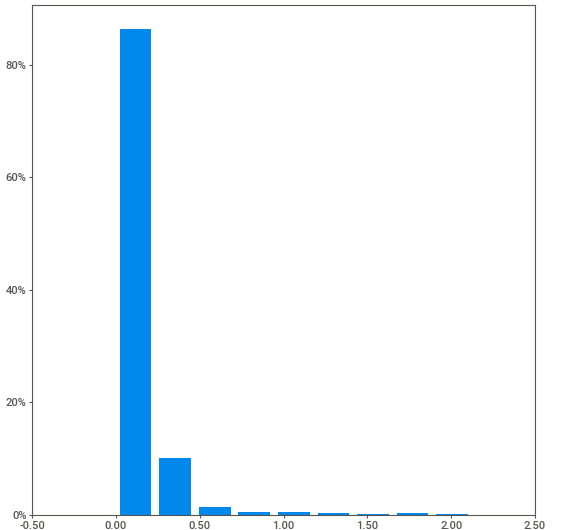
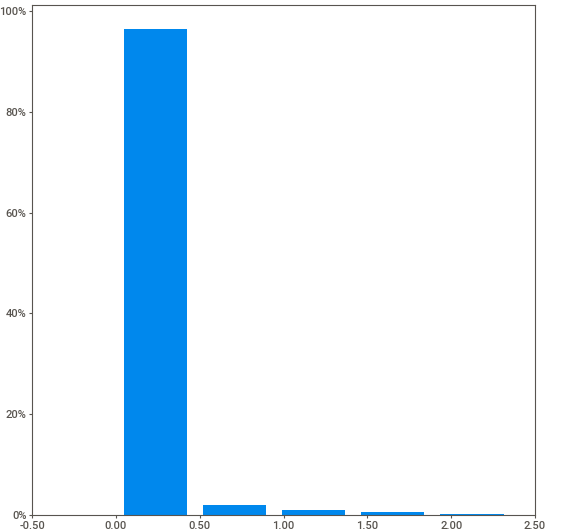
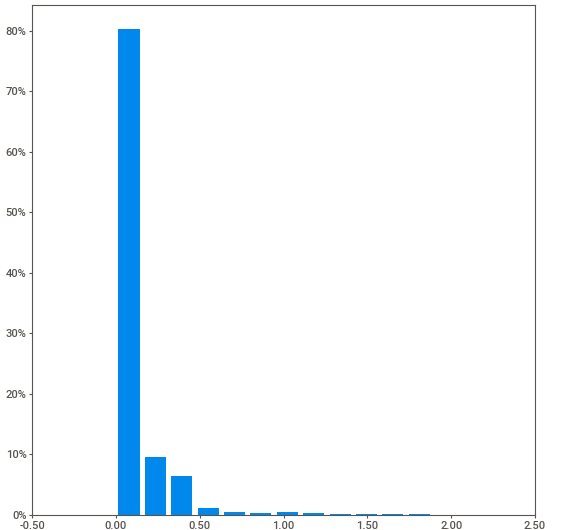
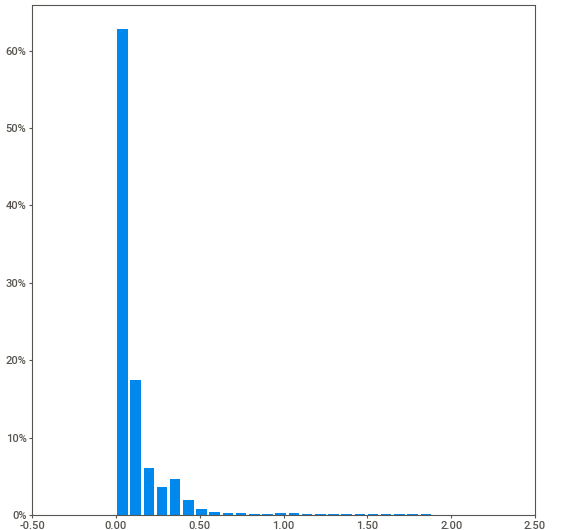
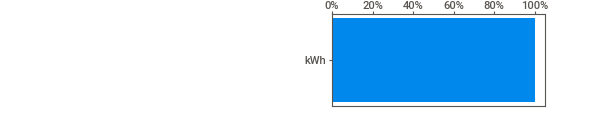
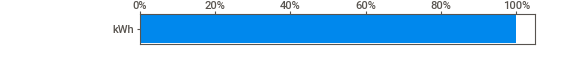
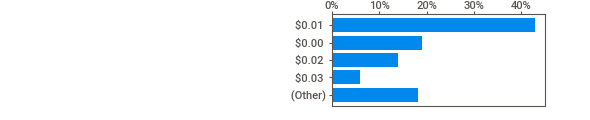
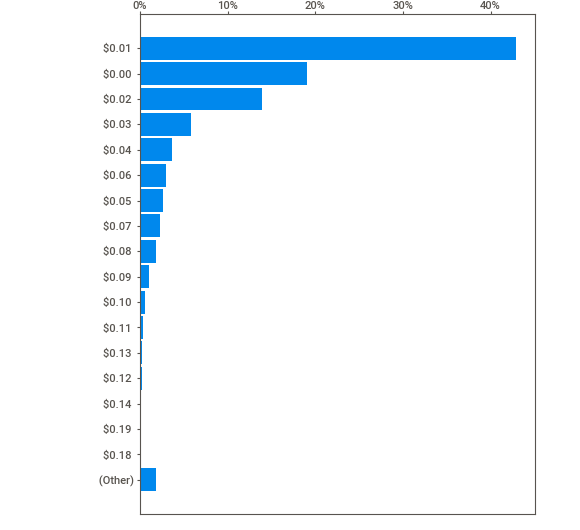
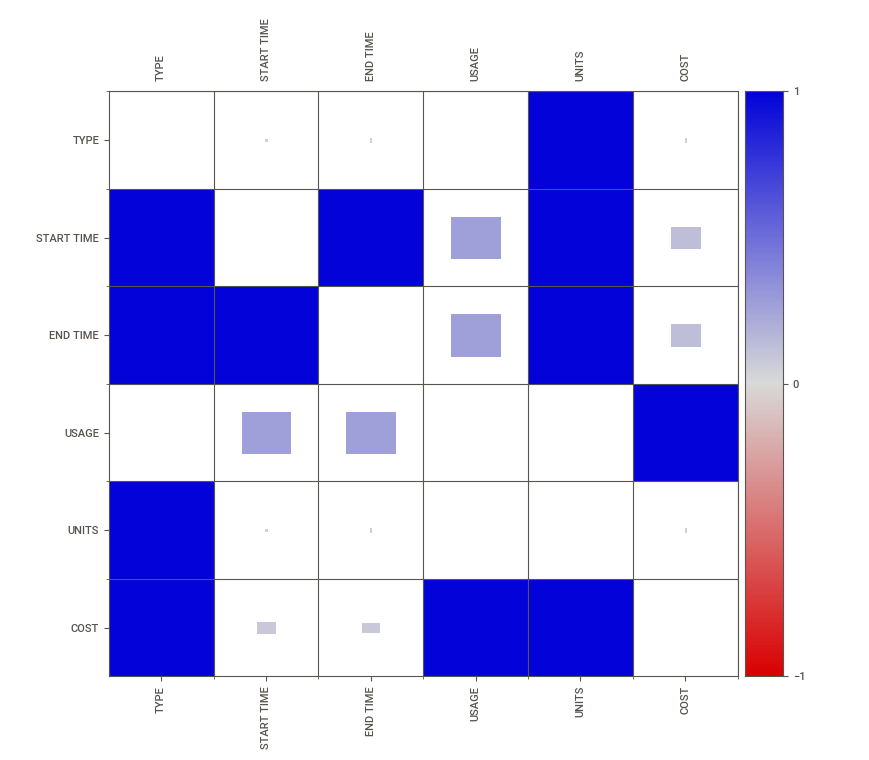
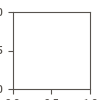

In [33]:
report.show_notebook()